# Khai báo thư viện

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna
#------------------------------------------------------------------
from sklearn import preprocessing #has preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#------------------------------------------------------------------
from scipy.stats import uniform
#------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import 
# from sklearn.model_selection import 
#------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
#------------------------------------------------------------------
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import make_scorer
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Data

In [7]:
path = r"D:\_Dev\_Group Project\Affinity-Propagation-ML-UEH\Data\Shopping Mall Customer Segmentation Data (Base)\data_preprocessed.csv"
path = path.replace('\\','/')
df = pd.read_csv(path)

In [8]:
df.head()

,Unnamed: 0,customer_id,age,annual_income,spending_score,gender_Female
0,0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,-1.145516,0.798813,1.337059,0.0
1,1,1770b26f-493f-46b6-837f-4237fb5a314e,0.180335,1.442076,1.545929,1.0
2,2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,0.369742,-0.743208,0.884507,1.0
3,3,9795712a-ad19-47bf-8886-4f997d6046e3,-1.476979,-1.038953,0.223086,0.0
4,4,64139426-2226-4cd6-bf09-91bce4b4db5e,-1.429627,0.842317,0.884507,0.0


In [9]:
data = df.drop(columns=["customer_id",],axis=1,)

In [10]:
X = data.copy()

# AP BASE

## 1. Algorithm's parameters

```
damping
preference
```

In [23]:
ap = AffinityPropagation(random_state=42 ,damping=0.609, preference=-294.857)
ap.fit(X)

AffinityPropagation(damping=0.609, preference=-294.857, random_state=42)

## 2. Cluster Visualization

In [24]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

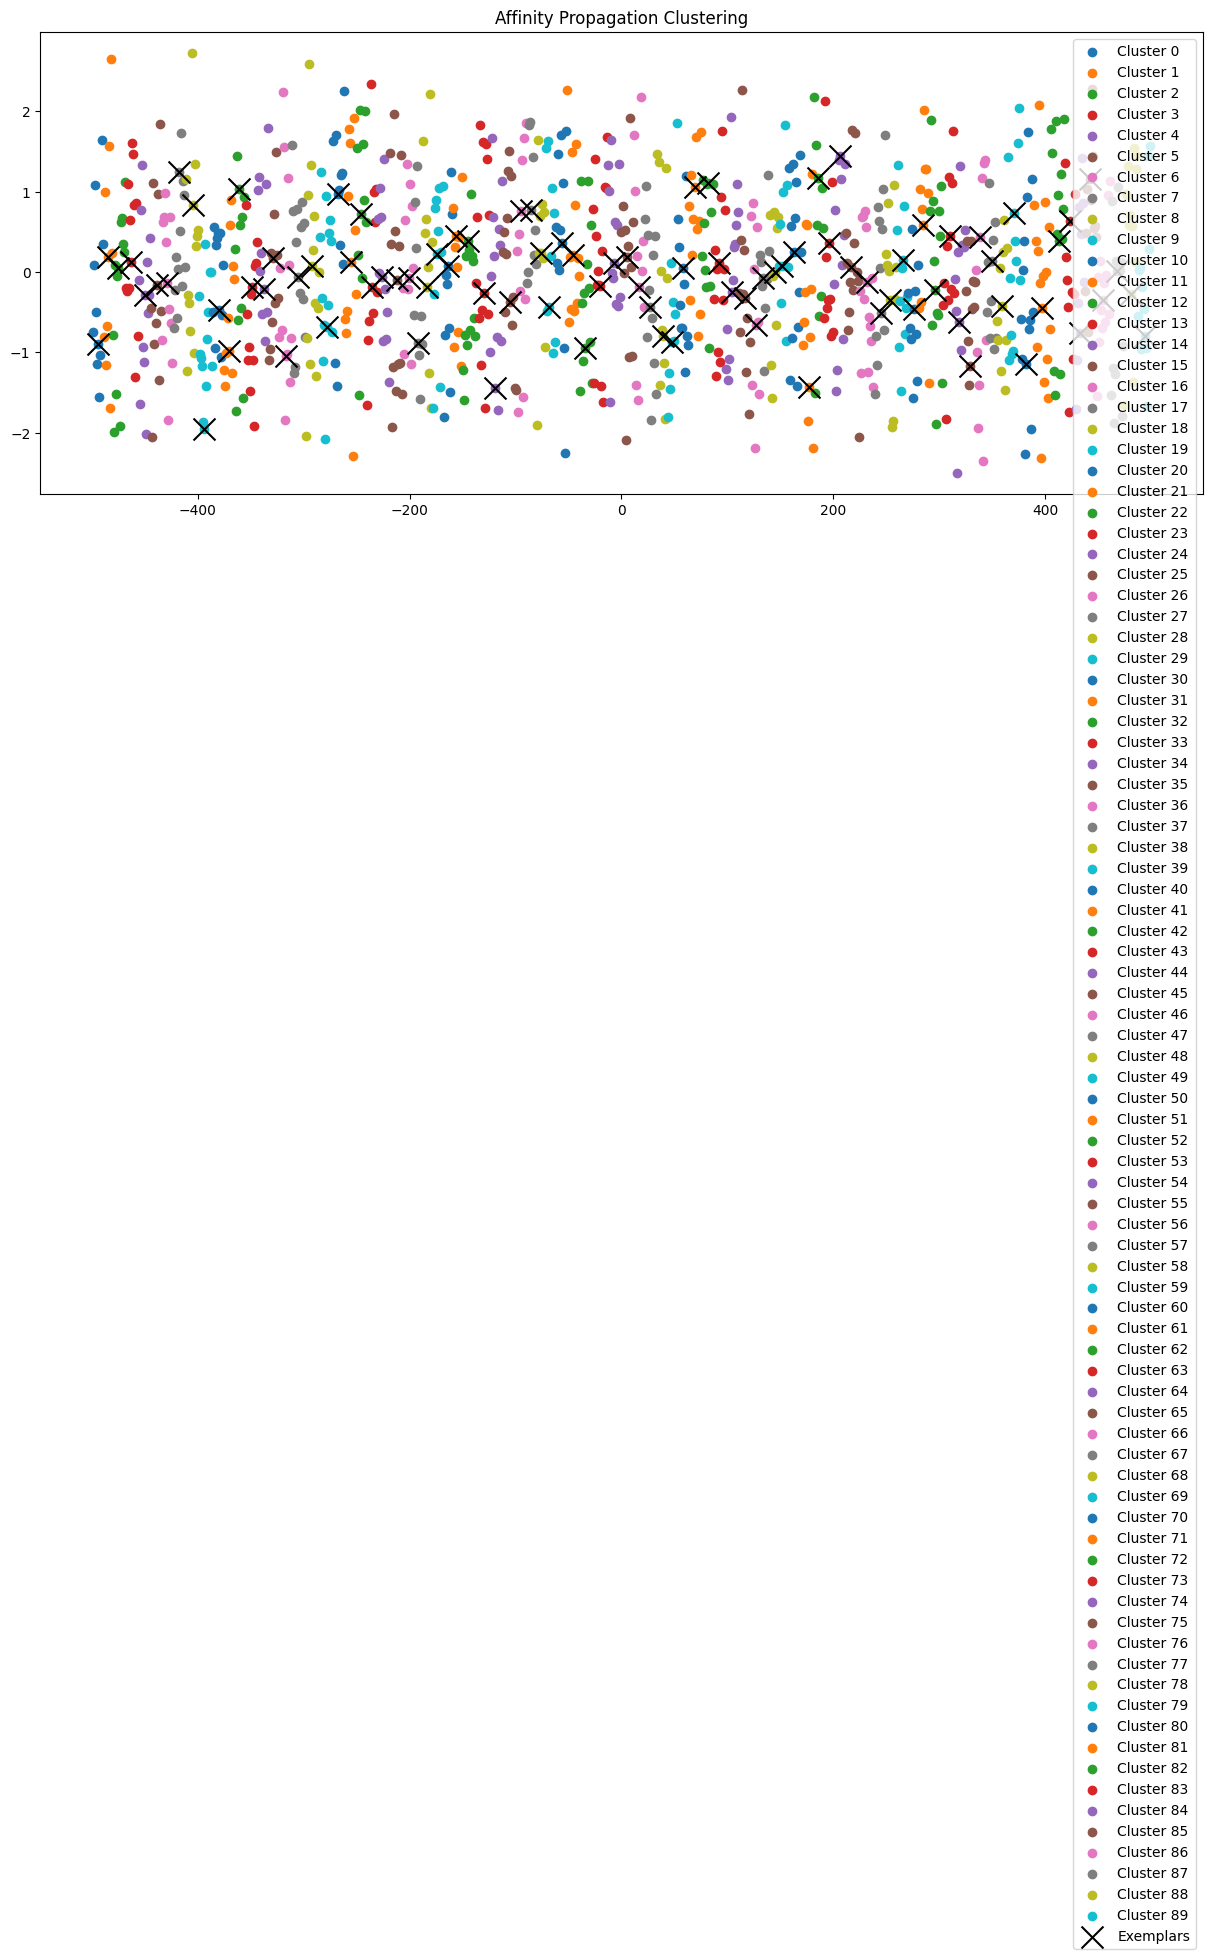

In [25]:
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

plt.figure(figsize=(15, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("Affinity Propagation Clustering")
plt.show()

# Hyperparameter Optimization

## Random Search

In [14]:
#Khởi tạo biến lưu trữ kết quả
best_score = -1
best_damping= None
best_pref= None
best_model = None
best_n_clusters = None
best_labels = None

#Thực hiện Random Search
for _ in range(20):
    damp = np.random.uniform(0.5, 0.9)
    pref = np.random.uniform(-300, 0)

    model = AffinityPropagation(
        damping=damp,
        preference=pref,
        random_state=42
    )
    labels = model.fit_predict(X)

    n_clusters = len(set(labels))
    if n_clusters <= 1 or n_clusters >= len(X):
        continue  # Bỏ qua trường hợp không hợp lệ

    score = silhouette_score(X, labels)

    if score > best_score:
        best_score = score
        best_damping = damp
        best_pref = pref
        best_model = model
        best_n_clusters = n_clusters
        best_labels = labels

#Tính các chỉ số đánh giá với tham số tốt nhất
silhouette_ap = silhouette_score(X, best_labels)
davies_bouldin_ap = davies_bouldin_score(X, best_labels)
calinski_harabasz_ap = calinski_harabasz_score(X, best_labels)


In [15]:
print("\nKết quả tốt nhất từ [Random Search]:")
print("-Tham số tối ưu:")
print(f"\t+ Damping: {best_damping:.3f}")
print(f"\t+ Preference: {best_pref:.3f}")
print(f"- Số lượng cụm: {best_n_clusters}")
print(f"- Silhouette Score: {silhouette_ap:.3f}")
print(f"- Davies Bouldie Score: {davies_bouldin_ap:.3f}")
print(f"- Calinski Harabasz Score: {calinski_harabasz_ap:.3f}")


Kết quả tốt nhất từ [Random Search]:
-Tham số tối ưu:
	+ Damping: 0.609
	+ Preference: -294.857
- Số lượng cụm: 90
- Silhouette Score: 0.408
- Davies Bouldie Score: 0.614
- Calinski Harabasz Score: 62191.142


## Bayesian Optimization

In [16]:
def objective(trial):
    damping = trial.suggest_float('damping', 0.5, 0.9)
    preference = trial.suggest_float('preference', -300, 0)

    model = AffinityPropagation(
        damping=damping,
        preference=preference,
        random_state=42
    )
    labels = model.fit_predict(X)

    n_clusters = len(set(labels))

    if n_clusters <= 1 or n_clusters >= len(X):
        return 0.0
    
    score = silhouette_score(X, labels)

    #Quyết định cắt bỏ trial này
    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return score #Vì Optuna maximize

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-05-06 19:11:52,757] A new study created in memory with name: no-name-c42d388c-433e-4979-bb2f-2c089f1f6b65
[I 2025-05-06 19:11:53,270] Trial 0 finished with value: 0.38428082330985164 and parameters: {'damping': 0.5370945770994144, 'preference': -153.95321678256462}. Best is trial 0 with value: 0.38428082330985164.
[I 2025-05-06 19:11:54,147] Trial 1 finished with value: 0.38377577600350893 and parameters: {'damping': 0.7230370299601644, 'preference': -162.87482118662277}. Best is trial 0 with value: 0.38428082330985164.
[I 2025-05-06 19:11:56,631] Trial 2 finished with value: 0.30213116227021564 and parameters: {'damping': 0.864736015482787, 'preference': -34.99000534485219}. Best is trial 0 with value: 0.38428082330985164.
[I 2025-05-06 19:11:57,710] Trial 3 finished with value: 0.40366334775303814 and parameters: {'damping': 0.8056627638468014, 'preference': -287.30921777561963}. Best is trial 3 with value: 0.40366334775303814.
[I 2025-05-06 19:11:58,351] Trial 4 finished wit

In [18]:
best = study.best_params

best_model = AffinityPropagation(
    damping=best['damping'],
    preference=best['preference'],
    random_state=42
)

best_labels = best_model.fit_predict(X)
best_n_clusters = len(set(best_labels))

silhouette_ap = silhouette_score(X, best_labels)
davies_bouldin_ap = davies_bouldin_score(X, best_labels)
calinski_harabasz_ap = calinski_harabasz_score(X, best_labels)

In [19]:
print("\nKết quả tốt nhất từ [Bayesian Optimization]:")
print("-Tham số tối ưu:")
print(f"\t+ Damping: {best['damping']:.3f}")
print(f"\t+ Preference: {best['preference']:.3f}")
print(f"- Số lượng cụm: {best_n_clusters}")
print(f"- Silhouette Score: {silhouette_ap:.3f}")
print(f"- Davies Bouldie Score: {davies_bouldin_ap:.3f}")
print(f"- Calinski Harabasz Score: {calinski_harabasz_ap:.3f}")


Kết quả tốt nhất từ [Bayesian Optimization]:
-Tham số tối ưu:
	+ Damping: 0.619
	+ Preference: -297.877
- Số lượng cụm: 88
- Silhouette Score: 0.410
- Davies Bouldie Score: 0.610
- Calinski Harabasz Score: 61283.565
